In [1]:
from os import path, walk
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import math
import csv

Directory structure:
```
out/parsec/
    {benchmark name}/
        {repl}/
            {assoc}
```

Important metrics: 
- Associativity
- Replacement Algorithm
- Benchmark
- ~~Accesses~~
- ~~Hits~~
- ~~Misses~~
- Miss Rate

In [35]:
important_stats = { 
    # "board.cache_hierarchy.l1dcaches.overallHits::total": "hits",
    # "board.cache_hierarchy.l1dcaches.overallMisses::total": "misses",
    # "board.cache_hierarchy.l1dcaches.overallAccesses::total": "accesses",
    "board.cache_hierarchy.l1dcaches.overallMissRate::total": "miss_rate",
 }

In [36]:
class Trial:
    def __init__(
        self, benchmark: str, repl: str, assoc: str, miss_rate: float
    ):
        self.benchmark = benchmark
        self.repl = repl
        self.assoc = assoc
        self.miss_rate = miss_rate

In [41]:
BASE_PATH = path.join("../", "out/parsec")

trials: [Trial] = []

for root, _, files in walk(BASE_PATH):
    # Only need folders with statistics
    if "stats.txt" not in files:
        continue
    
    parent_dirs = root.split("/")
    if len(parent_dirs) < 6:
        continue
    benchmark = parent_dirs[3]
    repl = parent_dirs[4]
    assoc = int(parent_dirs[5])
    miss_rate = 1

    stat_file = path.join(root, "stats.txt")
    f = open(stat_file, "r")
    lines = f.readlines()

    stats = dict()
    for line in lines[2:-2]:
        line_args = line.split()
        if line_args[0] not in important_stats.keys():
            continue
        # If recording things other than miss rate, this needs to change
        # print(stat_file, line_args)
        miss_rate = float(line_args[1])
        break
    
    if miss_rate == 1:
        print("!", benchmark, repl, assoc, line_args[1])
    trials.append(Trial(benchmark, repl, assoc, miss_rate))
print(trials)


! raytrace brrip 2 0.002546
! facesim rrip 8 0.012343
! facesim rrip 4 0.012343
! facesim brrip 8 0.014849
! facesim brrip 2 0.014043
! bodytrack rrip 16 0.015739
! bodytrack rrip 2 0.040983
! bodytrack rr 8 0.042785
! bodytrack nru 4 0.041600
! bodytrack sieve 8 0.037710
! bodytrack brrip 2 0.036865
! canneal rrip 4 0.038868
! canneal brrip 4 0.040245
! canneal brrip 2 0.040245
! vips nru 2 0.013817
! blackscholes rrip 2 0.001275
! blackscholes rr 8 0.001659
! blackscholes nru 16 0.003280
! blackscholes nru 4 0.000653
! blackscholes nru 2 0.000653
! blackscholes sieve 8 0.051307
! blackscholes brrip 2 0.017707
! blackscholes tree-plru 8 0.000540
! streamcluster brrip 4 0.007459
! dedup rrip 2 0.017072
! dedup nru 4 0.016009
[<__main__.Trial object at 0x116304790>, <__main__.Trial object at 0x116304890>, <__main__.Trial object at 0x116305690>, <__main__.Trial object at 0x116305210>, <__main__.Trial object at 0x116306410>, <__main__.Trial object at 0x1163052d0>, <__main__.Trial object a

In [38]:
algorithms = set()
benchmarks = set()
assocs = set()
for trial in trials:
    algorithms.add(trial.repl)
    benchmarks.add(trial.benchmark)
    assocs.add(trial.assoc)
algorithms = list(algorithms)
benchmarks = list(benchmarks)
assocs = sorted(list(assocs))

print(algorithms)
print(benchmarks)
print(assocs)

['nru', 'sieve', 'rr', 'rrip', 'tree-plru', 'brrip']
['freqmine', 'canneal', 'blackscholes', 'raytrace', 'fluidanimate', 'x264', 'vips', 'ferret', 'streamcluster', 'dedup', 'bodytrack', 'facesim', 'swaptions']
[2, 4, 8, 16]


In [39]:
avgs = dict()
for assoc in assocs:
    avg_assoc_group = []
    for algo in algorithms:
        data = []
        for trial in trials:
            if trial.repl != algo or trial.assoc != assoc:
                continue
            data.append(trial.miss_rate)
        np_data = np.array(data)
        avg_assoc_group.append(np_data)
    avgs[assoc] = avg_assoc_group
print(avgs)

{2: [array([0.014884, 0.003042, 0.015986, 0.041985, 0.040699, 0.013792, None,
       0.018856, None, 0.004648, 0.007492, 0.010195, 0.018094],
      dtype=object), array([0.014463, 0.002629, 0.015804, 0.039408, 0.040997, 0.016956,
       0.0166  , 0.01621 , 0.015245, 0.005867, 0.009185, 0.012104,
       0.018364]), array([0.015577, 0.002938, 0.016504, 0.042722, 0.045001, 0.015063,
       0.016029, 0.017152, 0.00328 , 0.005349, 0.009284, 0.011155,
       0.019465]), array([0.014724, 0.002616, 0.01557, None, 0.041102, 0.012927, 0.015371,
       0.017374, None, 0.004784, 0.007499, 0.010719, None], dtype=object), array([0.013929, 0.002593, 0.015739, 0.041897, 0.039994, 0.012153,
       0.015156, 0.019296, 0.002118, 0.004659, 0.00885 , 0.010242,
       0.017898]), array([0.015857, None, None, None, None, 0.017443, 0.016308, 0.01744,
       None, 0.005927, 0.007523, 0.011677, 0.019095], dtype=object)], 4: [array([0.0122, 0.002532, 0.012996, None, 0.038626, 0.010279, 0.013817,
       0.015048,

<Figure size 640x480 with 0 Axes>

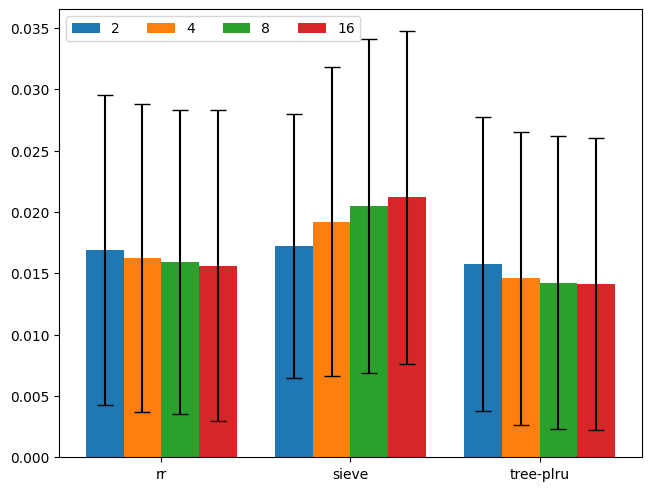

In [18]:
fig = plt.figure()
fig, ax = plt.subplots(layout='constrained')

x = np.arange(len(algorithms))
width = 0.2
multiplier = 0

for assoc, assoc_group in avgs.items():
    offset = width * multiplier
    rects = ax.bar(x + offset,
        height=[np.mean(trial_set) for trial_set in assoc_group],
        width=width,
        yerr=[np.std(trial_set) for trial_set in assoc_group],
        capsize=6,
        label=assoc
        )
    multiplier += 1

ax.set_xticks(x + width * (len(assocs) - 1) / 2, algorithms)
ax.legend(loc='upper left', ncols=len(assocs))

# ax.bar(algorithms,
#     height=[np.mean(avg) for avg in avgs],
#     yerr=[np.std(avg) for avg in avgs],
#     capsize=12
#     )

<Figure size 640x480 with 0 Axes>

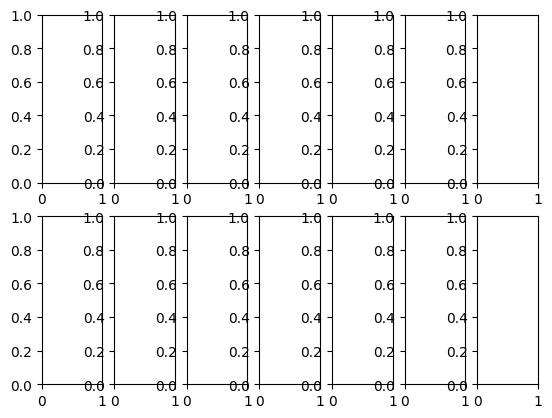

In [19]:
fig = plt.figure()
fig, axs = plt.subplots(2, math.ceil(len(benchmarks)/ 2))

for bench in benchmarks:
    pass